In [1]:
# Set-Ups
import csv
import math
import random
import string
import numpy as np
import pandas as pd 
import pylab as plt

# Load the data
df = pd.read_csv("CHD_preprocessed.csv", sep=",")
#df = pd.read_csv("framingham.csv", sep=",")
## data split
from sklearn.model_selection import train_test_split

df_X = df[df.columns[df.columns != 'TenYearCHD']].copy()
df_y = df['TenYearCHD'].copy()

x_train, x_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.30, random_state=4212)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=4212)
print("X train shape: ", x_train.shape)
print("X validation shape: ", x_val.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y validation shape: ", y_val.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (2893, 15)
X validation shape:  (620, 15)
X test shape:  (620, 15)
Y train shape:  (2893,)
Y validation shape:  (620,)
Y test shape:  (620,)


Tabular NN 1: TabNet

In [2]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
# Transfer data
x_train = x_train.to_numpy()
y_train = y_train.to_numpy().squeeze()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy().squeeze()
x_val = x_val.to_numpy()
y_val = y_val.to_numpy().squeeze()

In [4]:
# Use Default option to test TabNet
clf1 = TabNetClassifier()
clf1.fit(x_train,y_train,eval_set=[(x_val, y_val)])

Device used : cpu
epoch 0  | loss: 0.69815 | val_0_auc: 0.50385 |  0:00:00s
epoch 1  | loss: 0.49944 | val_0_auc: 0.4887  |  0:00:00s
epoch 2  | loss: 0.49714 | val_0_auc: 0.4606  |  0:00:00s
epoch 3  | loss: 0.45934 | val_0_auc: 0.4303  |  0:00:00s
epoch 4  | loss: 0.43749 | val_0_auc: 0.48285 |  0:00:00s
epoch 5  | loss: 0.41238 | val_0_auc: 0.49576 |  0:00:01s
epoch 6  | loss: 0.40798 | val_0_auc: 0.47906 |  0:00:01s
epoch 7  | loss: 0.40214 | val_0_auc: 0.46779 |  0:00:01s
epoch 8  | loss: 0.39789 | val_0_auc: 0.50504 |  0:00:01s
epoch 9  | loss: 0.39542 | val_0_auc: 0.51647 |  0:00:01s
epoch 10 | loss: 0.3904  | val_0_auc: 0.4881  |  0:00:01s
epoch 11 | loss: 0.39256 | val_0_auc: 0.54829 |  0:00:02s
epoch 12 | loss: 0.38845 | val_0_auc: 0.51152 |  0:00:02s
epoch 13 | loss: 0.38291 | val_0_auc: 0.4582  |  0:00:02s
epoch 14 | loss: 0.38295 | val_0_auc: 0.48268 |  0:00:02s
epoch 15 | loss: 0.38312 | val_0_auc: 0.48729 |  0:00:02s
epoch 16 | loss: 0.38053 | val_0_auc: 0.49663 |  0:00:

BEST ACCURACY SCORE ON VALIDATION SET : 0.46774193548387094
BEST ACCURACY SCORE ON TEST SET : 0.4935483870967742


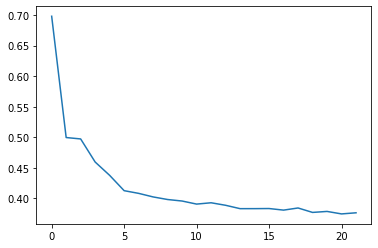

In [7]:
# plot losses
plt.plot(clf1.history['loss'])

# find and plot feature importance
y_pred = clf1.predict(x_test)
clf1.feature_importances_


# determine best accuracy for test set
preds = clf1.predict(x_test)
test_acc = accuracy_score(preds, y_test)

# determine best accuracy for validation set
preds_valid = clf1.predict(x_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

In [24]:
%%capture
# define the model
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
clf1_nopreproc.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc','accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

BEST ACCURACY SCORE ON VALIDATION SET : 0.7661290322580645
BEST ACCURACY SCORE ON TEST SET : 0.7338709677419355


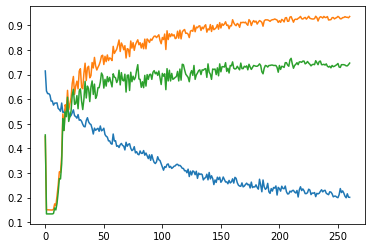

In [26]:
# plot losses
plt.plot(clf1_nopreproc.history['loss'])

# plot accuracy
plt.plot(clf1_nopreproc.history['train_accuracy'])
plt.plot(clf1_nopreproc.history['valid_accuracy'])

# find and plot feature importance
y_pred = clf1_nopreproc.predict(x_test)
clf1_nopreproc.feature_importances_


# determine best accuracy for test set
preds = clf1_nopreproc.predict(x_test)
test_acc = accuracy_score(preds, y_test)

# determine best accuracy for validation set
preds_valid = clf1_nopreproc.predict(x_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")